# Análise dos acidentes em rodovias e posicionamento de radares

## 1 - Entendimento do problema de negócio

Estou investigando como os radares nas estradas afetam a segurança e o tráfego. Quero entender se eles realmente ajudam a evitar acidentes e como podem ser melhorados. Vou usar dados do governo para ver onde acontecem mais acidentes e onde estão os radares. A ideia é descobrir se os radares estão nos lugares certos e se estão fazendo nosso trânsito mais seguro.

## 2 - Entendimento dos dados

### 2.1 - Dados Acidentes Rodovias PRF

#### 2.1.1 - Sobre os dados da PRF

Os dados de acidentes de trânsito utilizados neste estudo foram coletados da [base pública da Polícia Rodoviária Federal (PRF)](https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf) e abrangem o período de jan a dez de 2023. Essa base oficial e de acesso público contém registros abrangentes de acidentes ocorridos nas rodovias de todo o Brasil durante esse intervalo.

#### 2.1.2 - Dicionário de Dados

* `id` - Número de identificação único para cada registro no conjunto de dados.

* `data_inversa` - Data do acidente no formato YYYYMMDD (exemplo: 2023-03-13).

* `dia_semana` - Dia da semana em que o acidente ocorreu (exemplo: segunda-feira).

* `horario` - Hora do acidente no formato HH:MM:SS (exemplo: 18:10:00).

* `uf` - Unidade Federativa onde o acidente ocorreu (exemplo: ES - Espírito Santo).

* `br` - Número da rodovia onde o acidente ocorreu (exemplo: 101.0).

* `km` - Quilômetro exato da rodovia onde o acidente ocorreu (exemplo: 293,6).

* `municipio` - Município onde o acidente ocorreu (exemplo: CARIACICA).

* `causa_acidente` - Causa principal do acidente (exemplo: Ausência de sinalização).

* `tipo_acidente` - Tipo de acidente (exemplo: Atropelamento de Pedestre).

* `classificacao_acidente` - Classificação do acidente (exemplo: Com Vítimas Feridas).

* `fase_dia` - Fase do dia em que o acidente ocorreu (exemplo: Anoitecer).

* `sentido_via` - Sentido da via no momento do acidente (exemplo: Crescente).

* `condicao_metereologica` - Condição meteorológica no momento do acidente (exemplo: Céu Claro).

* `tipo_pista` - Tipo de pista (exemplo: Múltipla).

* `tracado_via` - Traçado da via no momento do acidente (exemplo: Reta).

* `uso_solo` - Se a área onde o acidente ocorreu é utilizada para fins agrícolas ou não (exemplo: Sim).

* `pessoas` - Número total de pessoas envolvidas no acidente (exemplo: 2).

* `mortos` - Número de pessoas mortas no acidente (exemplo: 0).

* `feridos_leves` - Número de pessoas com ferimentos leves no acidente (exemplo: 0).

* `feridos_graves` - Número de pessoas com ferimentos graves no acidente (exemplo: 1).

* `ilesos` - Número de pessoas ilesas no acidente (exemplo: 1).

* `ignorados` - Número de pessoas cujo estado não foi informado no acidente (exemplo: 0).

* `feridos` - Número total de pessoas feridas no acidente (exemplo: 1).

* `veiculos` - Número total de veículos envolvidos no acidente (exemplo: 1).

* `latitude` - Coordenada de latitude do local do acidente (exemplo: -20.324159).

* `longitude` - Coordenada de longitude do local do acidente (exemplo: -40.395290).

* `regional` - Regional de tráfego onde o acidente ocorreu (exemplo: SPRF-ES).

* `delegacia` - Delegacia responsável pelo registro do acidente (exemplo: DEL01-ES).

* `uop` - Unidade Operacional da Polícia Rodoviária responsável pelo atendimento do acidente (exemplo: UOP01-DEL01-ES).

In [48]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from scipy.spatial import cKDTree
import scipy.stats as stats
import statsmodels.api as sm

#### 2.1.3 - Carregando dados

In [3]:
# Importando dados
df00_prf = pd.read_csv('datatran2023.csv',
                       sep = ';',
                       encoding = 'latin1')

print(df00_prf.shape)
df00_prf.head()

(67723, 30)


,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,496519,2023-01-01,domingo,02:00:00,ES,101.0,114,SOORETAMA,Ausência de reação do condutor,Saída de leito carroçável,...,0,0,0,1,1,"-19,09484877","-40,05095848",SPRF-ES,DEL04-ES,UOP01-DEL04-ES
1,496543,2023-01-01,domingo,03:40:00,SP,116.0,"113,1",TAUBATE,Entrada inopinada do pedestre,Atropelamento de Pedestre,...,0,0,4,0,2,"-23,0445658","-45,58259814",SPRF-SP,DEL02-SP,UOP02-DEL02-SP
2,496590,2023-01-01,domingo,01:40:00,MT,163.0,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,Tombamento,...,1,0,0,1,1,"-9,70020602","-54,87588757",SPRF-MT,DEL06-MT,UOP03-DEL06-MT
3,496610,2023-01-01,domingo,10:40:00,PR,376.0,"314,8",ORTIGUEIRA,Velocidade Incompatível,Tombamento,...,0,1,0,0,1,"-23,985512","-51,083555",SPRF-PR,DEL07-PR,UOP02-DEL07-PR
4,496659,2023-01-01,domingo,14:55:00,MG,116.0,"569,4",MANHUACU,Acumulo de água sobre o pavimento,Colisão frontal,...,2,1,0,2,2,"-20,10007457","-42,17884091",SPRF-MG,DEL06-MG,UOP03-DEL06-MG


In [ ]:
# Função para gerar metadados

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    param dataframe: DataFrame para o qual os metadados serão gerados.
    return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
        'amostra': dataframe.apply(lambda x: str(list(x.sample(3)) if len(x) > 3 else list(x)))
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [5]:
# Gerando metadados do dataframe
generate_metadata(df00_prf)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,amostra
0,id,int64,0,0.00,67723,"[543122, 500853, 544776]"
1,veiculos,int64,0,0.00,16,"[2, 2, 2]"
2,feridos,int64,0,0.00,40,"[1, 1, 1]"
3,ignorados,int64,0,0.00,13,"[0, 0, 0]"
4,ilesos,int64,0,0.00,53,"[1, 1, 0]"
5,feridos_graves,int64,0,0.00,16,"[0, 0, 1]"
6,feridos_leves,int64,0,0.00,34,"[3, 1, 1]"
7,mortos,int64,0,0.00,8,"[0, 0, 0]"
8,pessoas,int64,0,0.00,62,"[2, 1, 2]"
9,br,float64,159,0.23,118,"[20.0, 20.0, 60.0]"


In [6]:
# Análise estatística das variáveis numéricas
df00_prf.describe()

,id,br,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
count,67723.000000,67564.000000,67723.000000,67723.00000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000
mean,534999.042541,209.750488,2.463461,0.08300,0.878313,0.279536,1.063789,0.158823,1.157849,1.755415
std,21905.835644,129.452779,2.250097,0.33124,1.103140,0.616570,1.809936,0.462045,1.227705,0.812242
min,496506.000000,10.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,516177.000000,101.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,535066.000000,158.000000,2.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000
75%,553890.500000,324.000000,3.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000
max,589495.000000,498.000000,94.000000,7.00000,61.000000,29.000000,61.000000,39.000000,62.000000,82.000000


- A quantidade de acidentes registrados é de 67.723 ao longo das rodovias federais brasileiras.

- O maior número de pessoas envolvidas em um acidente registrado, foi de 94 pessoas. Sendo que, a média de pessoas envolvidas por acidente é de 2.46 pessoas por acidente, que se aproxima da mediana, 2.

- Já a quantidade de vítimas fatais nos acidentes registrados, tem a média de 0.08 pessoas, o que leva-se a considerar que um pequena parcela dos acidentes há vítimas fatais.

- A quantidade de feridos, dentre graves e leves, é de certa de 1.16 pessoas por acidente, sendo que o acidente com maior número de feridos houve 62 pessoas que não passaram ilesas. Desta média mencionada, 0.88 correspondem a pessoas com ferimentos leves e 0.28 à ferimentos mais graves.

- A média de veículos envolvidos em cada acidente é cerca de 1.76. Ou seja, isso indica que a maioria dos acidentes envolve um ou dois veículos.

In [7]:
# Análise estatística das variáveis tipo objeto
df00_prf.describe(include = 'object')

,data_inversa,dia_semana,horario,uf,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,latitude,longitude,regional,delegacia,uop
count,67723,67723,67723,67723,67564,67723,67723,67723,67723,67723,67723,67723,67723,67723,67723,67723,67723,67719,67705,67691
unique,365,7,1406,27,7637,1825,75,16,3,4,3,10,3,466,2,35961,35957,28,151,394
top,2023-12-23,domingo,19:00:00,MG,1,BRASILIA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,"-23,52251783","-46,5855702",SPRF-MG,DEL01-PR,UOP01-DEL01-SP
freq,301,11263,954,9000,332,977,9850,12903,51907,37302,36682,43123,33330,37753,39294,80,80,8984,2357,1119


- Dia com mais acidentes: No período de tempo considerado em nossa base de dados, o dia 23/Dez/2023 foi a data que apresentou mais registros de acidentes nas rodovias federais, com 301 acidentes registrados.

- Dia da semana e horário com mais ocorrencias: o dia da semana mais comum de acontecer acidentes é o domingo, com 11263 registros. Enquanto o horário mais comum de ocorrer acidentes são as 19 horas.

- Causa de acidente mais comum: a reção tardia ou ineficiência do condutor são as causas mais frequentes de acidentes, dentre as 75 causas encontradas na base de dados.

- Fase do dia e condição climática mais frequentes: a maioria dos acidentes ocorrem em plena luz do dia com o céu claro. Apesar de que podem ser consideradas as melhores condições para se dirigir, é a condição em que ocorrem mais casos de acidentes.

- Traçado da pista com mais acidentes: outra observação interessante é que o traçado da via em que ocorreu mais acidentes foram em trechos de reta nessas rodovias, com 37.753 registros de acidentes neste traçado.   

### 2.2 - Dados Radares Rodovias Federais

#### 2.2.1 - Sobre os dados dos Radares nas Rodovias Federais

Os dados sobre os radares de trânsito nas rodovias federais do Brasil são acessíveis ao público por meio do portal "Dados.gov.br" do governo federal. Os dados foram acessados pelo link: [Acesso aos Dados de Radares](https://dados.gov.br/dados/conjuntos-dados/radar). Essas informações são fornecidas pela Agência Nacional de Transportes Terrestres (ANTT), uma entidade responsável por regulamentar e fiscalizar o transporte terrestre no país.

#### 2.2.2 - Dicionário de Dados

- `concessionaria`: Nome da Concessionária que prestou as informações.

- `ano_do_pnv_snv`: Ano que representa as informações no Plano Nacional de Viação e Sistema Nacional de Viação. Ex.: 2017

- `tipo_de_radar`: Tipo de radar (Redutor ou Controlador).

- `rodovia`: Rodovia responsável pela concessionária. Ex.: BR-116.

- `uf`: Sigla do Estado da rodovia. Ex.: SP.

- `km_m`: Representação do quilômetro mais a metragem. Ex.: 317,940.

- `Município`: Município da localização do radar.

- `tipo_de_pista`: Tipo da pista que está localizada a sinalização (principal ou marginal).

- `sentido`: Representação da ordem crescente ou decrescente ou crescente/decrescente.

- `situacao`: Situação atual (ativo ou inativo).

- `data_da_inativacao`: Data de registro, caso a situação seja dada como inativo.

- `latitude`: Representação de Coordenadas. Ex.: -22,490967.

- `longitude`: Representação de Coordenadas. Ex.: -44,561228

- `velocidade_leve`: Velocidade da Rodovia veículos leves

#### 2.2.3 - Visualização da Base de Dados

In [8]:
# Importando dados
df00_radar = pd.read_csv('dados_dos_radares.csv',
                         sep = ';',
                         encoding = 'latin1')

print(df00_radar.shape)
df00_radar.head()

(640, 15)


,concessionaria,ano_do_pnv_snv,tipo_de_radar,rodovia,uf,km_m,municipio,tipo_pista,sentido,situacao,data_da_inativacao,latitude,longitude,velocidade_leve,velocidade_pesado
0,AUTOPISTA FERNÃO DIAS,2007,Controlador,BR-381,SP,"78,200",São Paulo,Principal,Crescente,Ativo,NaN,"-23,401335","-46,575964",80,60
1,AUTOPISTA FERNÃO DIAS,2007,Controlador,BR-381,SP,"76,400",São Paulo,Principal,Decrescente,Ativo,NaN,"-23,387687","-46,569328",80,60
2,AUTOPISTA FERNÃO DIAS,2007,Controlador,BR-381,SP,"75,650",São Paulo,Principal,Crescente,Ativo,NaN,"-23,384708","-46,564716",80,60
3,AUTOPISTA FERNÃO DIAS,2007,Controlador,BR-381,SP,"73,060",São Paulo,Principal,Decrescente,Ativo,NaN,"-23,368741","-46,554044",80,60
4,AUTOPISTA FERNÃO DIAS,2007,Controlador,BR-381,SP,"70,200",Mairiporã,Principal,Decrescente,Ativo,NaN,"-23,349188","-46,556532",80,60


In [9]:
# Metadados
generate_metadata(df00_radar)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,amostra
0,ano_do_pnv_snv,int64,0,0.0,11,"[2020, 2009, 2010]"
1,velocidade_leve,int64,0,0.0,8,"[60, 80, 100]"
2,velocidade_pesado,int64,0,0.0,7,"[80, 60, 80]"
3,data_da_inativacao,float64,640,100.0,0,"[nan, nan, nan]"
4,concessionaria,object,0,0.0,20,"['AUTOPISTA PLANALTO SUL', 'MSVIA', 'CONCEBRA']"
5,tipo_de_radar,object,0,0.0,2,"['Controlador', 'Controlador', 'Controlador']"
6,rodovia,object,0,0.0,20,"['BR-101', 'BR-393', 'BR-393']"
7,uf,object,0,0.0,13,"['GO', 'RJ', 'TO']"
8,km_m,object,0,0.0,607,"['70,200', '920,800', '5,178']"
9,municipio,object,0,0.0,187,"['Paulo Lopes', 'Alexânia', 'Balneário Camboriú']"


In [10]:
# Análise estatística das variáveis numéricas
df00_radar.describe()

,ano_do_pnv_snv,data_da_inativacao,velocidade_leve,velocidade_pesado
count,640.000000,0.0,640.000000,640.000000
mean,2015.828125,NaN,71.390625,67.046875
std,4.776228,NaN,20.822761,15.560402
min,2003.000000,NaN,40.000000,40.000000
25%,2014.000000,NaN,60.000000,60.000000
50%,2017.000000,NaN,60.000000,60.000000
75%,2020.000000,NaN,80.000000,80.000000
max,2021.000000,NaN,110.000000,100.000000


- A tabela conta com o registro de 640 radares presentes nas rodovias federais.

- Os dados analisados contam com radares, que representam informações no Plano Nacional de Viação e Sistema Nacional de Viação, do ano de 2003 até 2021.

- A velocidade máxima permitida dentre todos os radares analisados é de 110km/h, para veículos leves. Sendo que, a velocidade máxima média, dentre todos os radares, é de 71.39 km/h.

In [11]:
# Análise estatística das variáveis tipo objeto
df00_radar.describe(include = 'object')

,concessionaria,tipo_de_radar,rodovia,uf,km_m,municipio,tipo_pista,sentido,situacao,latitude,longitude
count,640,640,640,640,640,640,640,640,640,640,640
unique,20,2,20,13,607,187,2,3,1,612,611
top,CONCEBRA,Controlador,BR-101,GO,"504,000",Anápolis,Principal,Crescente,Ativo,"-12,954695","-38,471467"
freq,102,478,137,149,3,26,617,279,640,4,4


- A concessionária com o maior número de radares registrados é a Concebra.

- Na base de dados, encontramos dois tipos de radares, sendo o "Controlador" o mais comum em rodovias federais, com 478 unidades.

- A análise abrange registros de radares em 20 diferentes rodovias federais, destacando-se a BR-101, que possui a maior quantidade de radares.

- O estado de Goiás lidera em quantidade de radares registrados, com destaque para o município de Anápolis, que abriga 26 radares, a maior quantidade entre os municípios analisados.

## 3 - Preparação dos Dados

In [12]:
df01_prf = df00_prf.copy()
df01_radar = df00_radar.copy()

### 3.1 - Dados Acidentes Rodovias PRF

**Tratamento de Valores Nulos:**

- Para as variáveis de tipo "object", os valores nulos foram preenchidos com "desconhecido" para garantir a integridade dos dados.

- Nas variáveis numéricas com valores nulos, esses espaços vazios foram substituídos por "999". Esse valor foi escolhido por ser discrepante em relação aos demais dados das colunas, facilitando sua identificação durante as análises.

**Adequação e Formatação das Colunas:**

- Nas variáveis de latitude e longitude, a vírgula foi substituída por ponto, ajustando o tipo das variáveis para possibilitar análises futuras.

- As colunas "data_inversa" e "horario" foram convertidas para o formato datetime para facilitar o manuseio das informações de data e hora.

- A variável "km" foi dividida em duas colunas: "Km" para representar os valores em quilômetros e "m" para representar os valores em metros referentes ao local do acidente.

#### 3.1.1 - Limpeza dos Dados e Tratamento de Nulos

In [13]:
# Preenchendo valores nulos das variáveis "object"
var_categoricas = df01_prf.select_dtypes(include=['object']).columns
df01_prf[var_categoricas] = df01_prf[var_categoricas].fillna('desconhecido')

In [14]:
# Preenchendo valores nulos das variáveis "numéricas"
var_numericas = df01_prf.select_dtypes(include=['float64','int64']).columns
df01_prf[var_numericas] = df01_prf[var_numericas].fillna(999)

#### 3.1.2 - Adequação dos Tipos das Colunas

In [15]:
# Ajustando valores dados colunas latitude e longitude. Alterando tipo para numérico
df01_prf['latitude'] = df01_prf['latitude'].str.replace(',','.').astype(float)
df01_prf['longitude'] = df01_prf['longitude'].str.replace(',','.').astype(float)

In [16]:
# Alterando colunas `horário` e `data_inversa` para datetime
df01_prf['data_inversa'] = pd.to_datetime(df01_prf['data_inversa'], format='%Y-%m-%d')
df01_prf['horario'] = pd.to_datetime(df01_prf['horario'], format='%H:%M:%S')

In [17]:
# Substituindo os valores 'desconhecido' por "0" na coluna 'km' para poder convertê-los para inteiros
df01_prf['km'] = df01_prf['km'].replace('desconhecido', 0)

# Ajustando valores da coluna km. Alterando tipo para numérico
df01_prf['km'] = df01_prf['km'].str.replace(',','.').astype(float)

# Dividindo a coluna 'km' em 'km' e 'm', considerando o ponto decimal
df01_prf[['km', 'm']] = df01_prf['km'].apply(lambda x: str(x).split('.', 1) if pd.notna(x) else ['0', '0']).apply(pd.Series)

# Convertendo as colunas 'km' e 'm' para int64
df01_prf['km'] = df01_prf['km'].astype(int)
df01_prf['m'] = df01_prf['m'].astype(int)

# Substituindo os valores NaN de 'km' por 'desconhecido' e os valores 0 de 'm' por 'desconhecido'
df01_prf['km'] = df01_prf['km'].astype(str).replace('0', 'desconhecido')
df01_prf['m'] = df01_prf['m'].astype(str).replace('0', 'desconhecido')

In [18]:
# Verificando metadados para validar que as transformações foram efetuadas
generate_metadata(df01_prf)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,amostra
0,id,int64,0,0.0,67723,"[497936, 529470, 558232]"
1,data_inversa,datetime64[ns],0,0.0,365,"[Timestamp('2023-01-28 00:00:00'), Timestamp('..."
2,horario,datetime64[ns],0,0.0,1406,"[Timestamp('1900-01-01 07:10:00'), Timestamp('..."
3,veiculos,int64,0,0.0,16,"[2, 2, 1]"
4,feridos,int64,0,0.0,40,"[1, 1, 1]"
5,ignorados,int64,0,0.0,13,"[0, 0, 0]"
6,ilesos,int64,0,0.0,53,"[1, 3, 1]"
7,feridos_graves,int64,0,0.0,16,"[0, 0, 0]"
8,feridos_leves,int64,0,0.0,34,"[0, 1, 1]"
9,mortos,int64,0,0.0,8,"[0, 0, 0]"


### 3.2 - Dados Radares Rodovias Federais

Para os dados dos radares das rodovias federais, foram realizados os seguintes tratamentos:

**Tratamento de Valores Nulos:**

- A variável `data_da_inativacao` apresenta 100% de valores nulos, o que indica que todos os radares registrados na tabela estão ativos. Nesse sentido, iremos remover essa coluna durante a etapa de limpeza dos dados.

**Adequação e Formatação das Colunas:**

- Da mesma forma que fizemos na tabela de acidentes, será necessário realizar tratamentos nas colunas `latitude` e `longitude` para garantir que estejam no formato correto.

- Conforme o dicionário de dados, a coluna `km_m` contém duas informações relevantes para nossa análise. Portanto, iremos dividir essa coluna em duas novas colunas, uma para o valor em quilômetros (km) e outra para o valor em metros (m).

- A coluna `ano_do_pnv_snv` precisará passar por um ajuste para ser convertida para o formato datetime.

#### 3.2.1 - Limpeza dos Dados e Tratamento de Nulos

In [19]:
# Excluindo coluna nula ´data_da_inativacao´
df01_radar.drop(columns=['data_da_inativacao'], inplace=True)

In [20]:
df01_radar.shape

(640, 14)

#### 3.2.2 - Adequação dos Tipos das Colunas

In [21]:
# Ajustando valores dados colunas latitude e longitude. Alterando tipo para numérico
df01_radar['latitude'] = df01_radar['latitude'].str.replace(',','.').astype(float)
df01_radar['longitude'] = df01_radar['longitude'].str.replace(',','.').astype(float)

In [22]:
# Alterando coluna `ano_do_pnv_snv ` para datetime
df01_radar['ano_do_pnv_snv '] = pd.to_datetime(df01_radar['ano_do_pnv_snv'], format='%Y')

In [23]:
# Separando variável km_m em duas colunas: km e m
df01_radar[['km', 'm']] = df01_radar['km_m'].str.split(',', expand=True).astype(int)

In [24]:
generate_metadata(df01_radar)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,amostra
0,m,int64,0,0.0,203,"[750, 800, 720]"
1,ano_do_pnv_snv,int64,0,0.0,11,"[2016, 2009, 2019]"
2,ano_do_pnv_snv,datetime64[ns],0,0.0,11,"[Timestamp('2017-01-01 00:00:00'), Timestamp('..."
3,velocidade_pesado,int64,0,0.0,7,"[80, 60, 90]"
4,velocidade_leve,int64,0,0.0,8,"[110, 40, 50]"
5,km,int64,0,0.0,400,"[424, 324, 394]"
6,longitude,float64,0,0.0,611,"[-40.828111, -44.007077, -50.623378]"
7,latitude,float64,0,0.0,612,"[-13.984564, -16.227873, -13.459724]"
8,situacao,object,0,0.0,1,"['Ativo', 'Ativo', 'Ativo']"
9,concessionaria,object,0,0.0,20,"['ECO101 CONCESSIONARIA DE RODOVIAS S/A', 'CRO..."


## 4 - Análise Exploratória

### 4.1 - Visualizando a distribuição dos acidentes e radares em um mapa

In [27]:
import folium
from IPython.display import display

# Criando um mapa centrado nas coordenadas do Brasil
m = folium.Map(location=[-14.235004, -51.92528], zoom_start=4)

# Amostragem aleatória dos acidentes e radares
sample_size = 100  # Número de pontos a serem amostrados

if len(df01_prf) > sample_size:
    df01_prf_sample = df01_prf.sample(n=sample_size, random_state=42)

if len(df01_radar) > sample_size:
    df01_radar_sample = df01_radar.sample(n=sample_size, random_state=42)

# Adicionando marcadores para cada acidente com tag de motivo
for index, row in df01_prf_sample.iterrows():
    tipo_acidente = row['tipo_acidente']
    folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='red'),
                  popup=folium.Popup(f'Tipo do Acidente: {tipo_acidente}', parse_html=True)).add_to(m)

# Adicionando marcadores para cada radar com tag de velocidade
for index, row in df01_radar_sample.iterrows():
    velocidade_leve = row['velocidade_leve']
    folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='blue'),
                  popup=folium.Popup(f'Velocidade do Radar: {velocidade_leve}', parse_html=True)).add_to(m)

# Exibindo o mapa
display(m)

### 4.2 - Analisando a frequência de acidentes por rodovia

In [28]:
# Quantidade de rodovias presentes na tabela
df01_prf['br'].nunique()

119

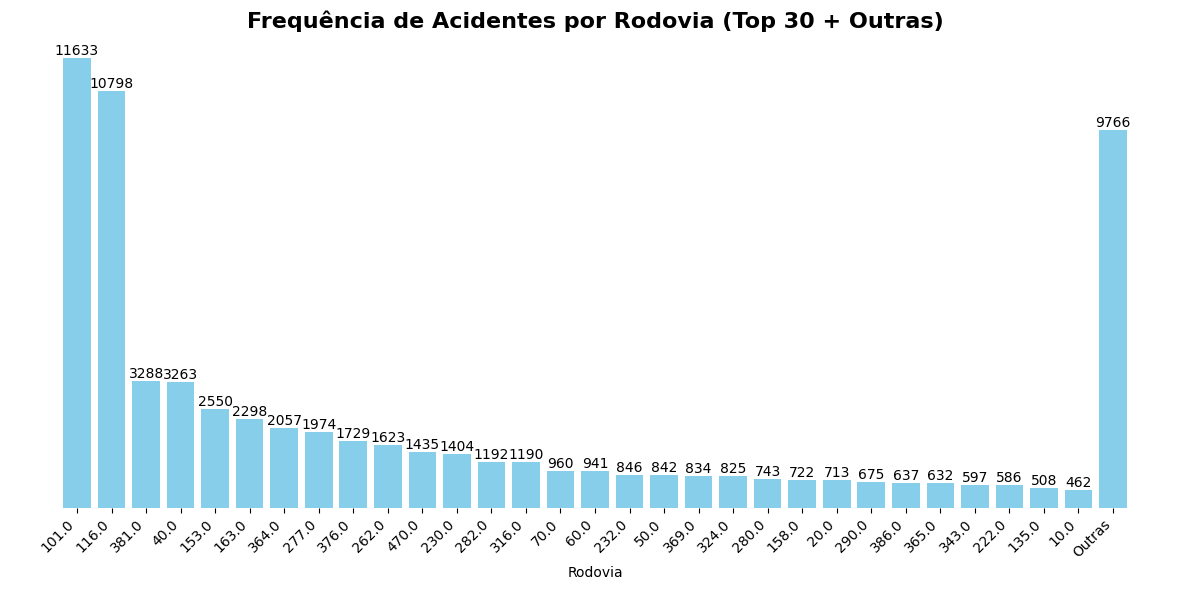

In [30]:
# Definindo o número de principais rodovias que desejamos exibir
top_n = 30

# Contagem de acidentes por rodovia
contagem_por_rodovia = df01_prf['br'].value_counts()

# Mantendo as principais rodovias e agrupando o restante em "Outras"
principais_rodovias = contagem_por_rodovia.head(top_n)
outras_rodovias = pd.Series(contagem_por_rodovia.iloc[top_n:].sum(), index=['Outras'])

# Concatenando as principais rodovias com "Outras" e convertendo o índice em strings
contagem_resumida = pd.concat([principais_rodovias, outras_rodovias]).rename(lambda x: str(x))

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))

# Removendo as grades do gráfico
plt.grid(False)

# Removendo as bordas do gráfico
plt.box(on=None)

# Criando as barras sem bordas
bars = plt.bar(contagem_resumida.index, contagem_resumida.values, color='skyblue', linewidth=0)

# Adicionando os valores acima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=10)

# Removendo a escala do eixo Y
plt.tick_params(axis='y', which='both', left=False)

# Definindo o eixo Y para não ser exibido
plt.yticks([])

plt.xlabel('Rodovia')

# Aumentando a fonte e coloque o título em negrito
plt.title(f'Frequência de Acidentes por Rodovia (Top {top_n} + Outras)', fontsize=16, fontweight='bold')

# Ajustando o espaço entre os rótulos do eixo X para melhor visualização
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibindo o gráfico
plt.show()

A análise da frequência de acidentes por rodovias revela o seguinte:

* **119 rodovias federais** têm registros de acidentes na base de dados analisada

* A **BR-101** é a rodovia com o maior número de registros de acidentes, totalizando **11.633 registros**

* A quantidade de acidentes registrados na **BR-101 e BR-116** representa **33,12%** do total de acidentes registrados

* As **30 rodovias com maior frequência de acidentes** acumulam um total de **57.957 acidentes**.

### 4.3 - Avaliando a gravidade dos acidentes (fatais, com feridos, sem vítimas)

Agora, realizando a análise e a visualização de dados relacionados à gravidade dos acidentes em rodovias federais. A lógica e as premissas utilizadas são as seguintes:

**Criação das Colunas de Categorias de Acidentes:**

* Serão criadas quatro novas colunas no DataFrame, da PRF, para categorizar os acidentes com base em sua gravidade. Para isso, foram consideradas as seguintes premissas:
  
  * **acidente_com_vitima_fatal:** Esta coluna é preenchida com True se houver pelo menos uma vítima fatal no acidente (mortos > 0).
  
  * **acidente_com_vitima:** Esta coluna é preenchida com True se o acidente não tiver vítimas fatais (mortos = 0) e houver pelo menos uma vítima com ferimentos (feridos > 0).
  
  * **acidente_sem_vitima:** Esta coluna é preenchida com True se o acidente não tiver vítimas fatais (mortos = 0), nenhum ferido (feridos = 0) e pelo menos uma pessoa saiu ilesa (ilesos > 0).
  
  * **acidente_sem_informacao:** Esta coluna é preenchida com True se todas as categorias anteriores de vítimas (mortos, feridos e ilesos) forem iguais a zero e houver pelo menos um registro como "ignorado" (ignorados > 0).

**Cálculo do Número de Acidentes em Cada Categoria:**

* Em seguida, é feito o calcula do número de acidentes em cada categoria de gravidade, somando os valores das colunas criadas anteriormente, com isso, teremos as seguintes informações.

  * **acidente_com_vitima_fatal:** Número de acidentes com vítimas fatais.

  * **acidente_com_vitima:** Número de acidentes com vítimas não fatais.

  * **acidente_sem_vitima:** Número de acidentes sem vítimas.

  * **acidente_sem_informacao:** Número de acidentes sem informações de vítimas.

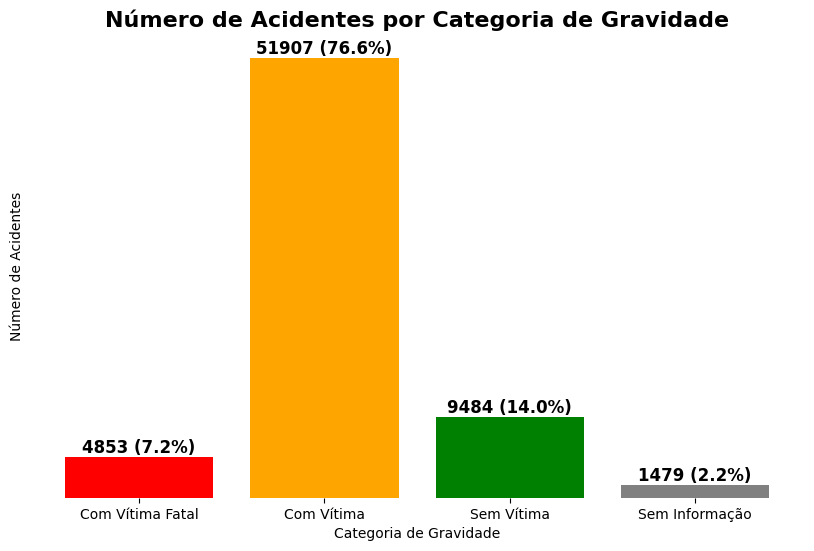

In [31]:
# Criando as colunas para categorias de acidentes
df01_prf['acidente_com_vitima_fatal'] = df01_prf['mortos'] > 0
df01_prf['acidente_com_vitima'] = ((df01_prf['mortos'] == 0) & (df01_prf['feridos'] > 0))
df01_prf['acidente_sem_vitima'] = (df01_prf['mortos'] == 0) & (df01_prf['feridos'] == 0) & (df01_prf['ilesos'] > 0)
df01_prf['acidente_sem_informacao'] = (df01_prf['mortos'] == 0) & (df01_prf['feridos'] == 0) & (df01_prf['ilesos'] == 0) & (df01_prf['ignorados'] > 0)

# Calculando o número de acidentes em cada categoria
acidente_com_vitima_fatal = df01_prf['acidente_com_vitima_fatal'].sum()
acidente_com_vitima = df01_prf['acidente_com_vitima'].sum()
acidente_sem_vitima = df01_prf['acidente_sem_vitima'].sum()
acidente_sem_informacao = df01_prf['acidente_sem_informacao'].sum()
total_acidentes = df01_prf.shape[0]

# Criando um gráfico de barras
plt.figure(figsize=(10, 6))
categorias = ['Com Vítima Fatal', 'Com Vítima', 'Sem Vítima', 'Sem Informação']
quantidades = [acidente_com_vitima_fatal, acidente_com_vitima, acidente_sem_vitima, acidente_sem_informacao]

# Criando as barras
bars = plt.bar(categorias, quantidades, color=['red', 'orange', 'green', 'gray'])

# Adicione os valores acima de cada barra
for bar, quantidade in zip(bars, quantidades):
    height = bar.get_height()
    plt.annotate(f'{quantidade} ({(quantidade/total_acidentes*100):.1f}%)',
                 (bar.get_x() + bar.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Removendo as grades do gráfico
plt.grid(False)

# Removendo as referências do eixo Y
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

# Removendo a borda do gráfico
plt.box(on=None)

plt.xlabel('Categoria de Gravidade')
plt.ylabel('Número de Acidentes')
plt.title('Número de Acidentes por Categoria de Gravidade', fontsize=16, fontweight='bold')

plt.show()

* Cerca de **7,2% dos acidentes** registrados resultaram em **vítimas fatais**, totalizando 4.853 registros

* **76,6% dos acidentes envolveram pelo menos uma vítima**, com ferimentos graves ou leves, totalizando 51.907 registros

* **14,0% dos acidentes não apresentaram vítimas**, o que equivale a 9.484 acidentes registrados.

* Apenas **2,2% dos registros de acidentes não continham informações** sobre o estado das pessoas envolvidas no acidente.

## 5 - Identificação de Zonas de Alto Risco

In [32]:
df02_prf = df01_prf.copy()
df02_radar = df01_radar.copy()

### 5.1 - Determinando áreas (por exemplo, segmentos de rodovias específicos) com alta frequência de acidentes graves

#### 5.1.1 - Agrupamento de Acidentes por Rodovia e KM da Rodovia

* Agrupando os dados de acidentes por "br" (número da rodovia) e "km" (quilômetro da rodovia).

* Calculando a frequência de acidentes com diferentes categorias de gravidade (vítima fatal, com vítima, sem vítima, sem informação) em cada segmento de rodovia e por km de cada rodovia.

* Nesse ponto, a variável `acidentes_por_rodovia_km` conterá as informações sobre cada segmento da rodovia em cada km quilômetro. Além disso, o agrupamento realizado irá incluir a contagem de acidentes em cada uma das diferentes categorias de gravidade.

* Após isso, o dataframe é ordenado com base no número de acidentes com vítimas fatais e acidentes com vítimas, em ordem decrescente, e, em seguida, mostra as 10 principais entradas com os maiores valores em ambas as categorias. Isso pode ajudar a identificar as rodovias e quilômetros mais críticos em termos de acidentes graves.

In [35]:
# Formatando valores da variável "br" para que fique igual ao valores da tabela de radares
df02_prf['rodovia_km'] = df02_prf['br'].astype(str) + ', km-' + df02_prf['km'].astype(str)

# Criando uma variável que representa a rodovia e o km da rodovia
df02_prf['rodovia_km'] = df02_prf['br'].astype(str) + ', km-' + df01_prf['km'].astype(str)

# Agrupando os acidentes por "br" (número da rodovia) e "km" (quilômetro da rodovia)
acidentes_por_rodovia_km = df02_prf.groupby(['rodovia_km'])[
    ['acidente_com_vitima_fatal', 'acidente_com_vitima', 'acidente_sem_vitima', 'acidente_sem_informacao']
].sum().reset_index()


# Alterando o nome da coluna "br" para "rodovia"
acidentes_por_rodovia_km.rename(columns={'br': 'rodovia'}, inplace=True)

In [36]:
# Filtrando acidentes por KM das Rodovias ordenando por maior ocorrencia de vítimas fatais e vítimas
acidentes_por_rodovia_km.sort_values(['acidente_com_vitima_fatal','acidente_com_vitima'], ascending = False).head(10)

,rodovia_km,acidente_com_vitima_fatal,acidente_com_vitima,acidente_sem_vitima,acidente_sem_informacao
1416,"BR-116, km-229",6,45,7,1
1398,"BR-116, km-212",6,23,2,0
1421,"BR-116, km-233",6,15,0,1
780,"BR-101, km-68",5,56,10,1
767,"BR-101, km-66",5,55,4,2
1823,"BR-116, km-6",5,45,7,0
1284,"BR-116, km-11",5,41,7,1
1409,"BR-116, km-222",5,39,6,1
810,"BR-101, km-73",5,34,2,1
1339,"BR-116, km-16",5,31,1,1


**Rodovias e Quilômetros Críticos:** As rodovias "BR-116" e "BR-101" aparecem frequentemente nas 10 principais entradas, o que sugere que essas rodovias têm uma alta incidência de acidentes, tanto com vítimas fatais quanto com vítimas em geral. Os quilômetros exatos, como "km-229" e "km-68", também são indicativos de áreas específicas propensas a acidentes.

**Acidentes com Vítimas Fatais:** A primeira coluna, "acidente_com_vitima_fatal", mostra a quantidade de acidentes com vítimas fatais. Dentre os registros analisados, a rodovia/km "BR-116, km-229" registrou 6 acidentes com vítimas fatais.

**Acidentes com Vítimas:** A coluna "acidente_com_vitima" mostra a quantidade de acidentes com pelo menos uma vítima, incluindo ferimentos graves ou leves.A "BR-101, km-68" registrou 56 acidentes com vítimas, indicando um alto risco nesse trecho.

**Acidentes Sem Vítimas:** A coluna "acidente_sem_vitima" mostra a quantidade de acidentes sem vítimas. Além de ter 5 acidentes com vítimas fatais e 56 acidentes com vítimas, a "BR-101, km-68" teve 10 acidentes sem vítimas.

**Falta de Informação:** A coluna "acidente_sem_informacao" indica a quantidade de acidentes em que não havia informações disponíveis. A maioria das entradas não possui acidentes sem informação, o que sugere um bom registro de dados.

Essas informações podem ser úteis para direcionar esforços de segurança e tomar medidas para reduzir a incidência de acidentes nessas áreas críticas.

### 5.2 - Comparando com a localização atual dos radares

Para esta análise, foi necessário envolver o cruzamento de informações sobre acidentes de trânsito em rodovias federais com dados de radares localizados nessas rodovias. Para isso, foram realizadas as etapas abaixo:

* **Criação da Variável "rodovia_km":** Foi criada uma nova variável chamada "rodovia_km" no df02_radar. Essa variável combina informações da "rodovia" e do "km" da rodovia, transformando essas informações em uma única identificação para cada radar.

* **Agrupamento de Radares por "rodovia" e "km":** Os radares foram agrupados com base na variável "rodovia_km" para calcular a contagem de radares em cada km das rodovias. O resultado foi armazenado no DataFrame radares_por_rodovia_km, incluindo a quantidade de radares em cada grupo.

* **União de Dados de Acidentes e Radares:** Os dados de acidentes (anteriormente analisados) e os dados de radares foram unidos por meio da variável "rodovia_km", garantindo que as informações correspondessem às mesmas localizações nas rodovias.

* **Preenchimento de Valores NaN:** Como nem todos os locais de acidentes tinham radares correspondentes, os valores NaN (sem correspondência) na tabela resultante foram preenchidos com "0". Isso significa que, quando não havia radar em um local de acidente, o número de radares foi considerado zero.

* **Seleção de Colunas Relevantes:** A tabela resultante foi reduzida às colunas mais relevantes, incluindo "rodovia_km," a quantidade de acidentes com vítimas fatais, a quantidade de acidentes com vítimas e a quantidade de radares.

* **Top 10 Rodovias com Mais Acidentes Graves:** A tabela final foi classificada com base na quantidade de acidentes com vítimas fatais e a quantidade de acidentes com vítimas, em ordem decrescente. Os 10 principais resultados representam as rodovias e quilômetros com os maiores números de acidentes graves. Com isso, é possível avaliar a quantidade de radar nesses trechos de rodovia considerados ma das rodovias.

In [37]:
# Criando uma variável que representa a rodovia e o km da rodovia
df02_radar['rodovia_km'] = df02_radar['rodovia'].astype(str) + ', km-' + df01_prf['km'].astype(str)

# Agrupando os radares por "rodovia" e "km" e calculando a contagem de radares em cada grupo
radares_por_rodovia_km = df02_radar.groupby(['rodovia_km']).size().reset_index(name='quantidade_radares')

In [38]:
# Realizando o join entre as tabelas de acidentes e radares
acidentes_radar_por_rodovia = acidentes_por_rodovia_km.merge(radares_por_rodovia_km, on=['rodovia_km'], how='left')

# Preenchendo os valores NaN (sem correspondência de radares) com "0"
acidentes_radar_por_rodovia.fillna(0, inplace=True)

In [39]:
selec_colunas = ['rodovia_km','acidente_com_vitima_fatal','acidente_com_vitima','quantidade_radares']

top_10_rodovias = acidentes_radar_por_rodovia[selec_colunas].sort_values(['acidente_com_vitima_fatal','acidente_com_vitima'], ascending = False).head(10)
top_10_rodovias

,rodovia_km,acidente_com_vitima_fatal,acidente_com_vitima,quantidade_radares
1416,"BR-116, km-229",6,45,0.0
1398,"BR-116, km-212",6,23,0.0
1421,"BR-116, km-233",6,15,0.0
780,"BR-101, km-68",5,56,1.0
767,"BR-101, km-66",5,55,0.0
1823,"BR-116, km-6",5,45,0.0
1284,"BR-116, km-11",5,41,0.0
1409,"BR-116, km-222",5,39,0.0
810,"BR-101, km-73",5,34,1.0
1339,"BR-116, km-16",5,31,0.0


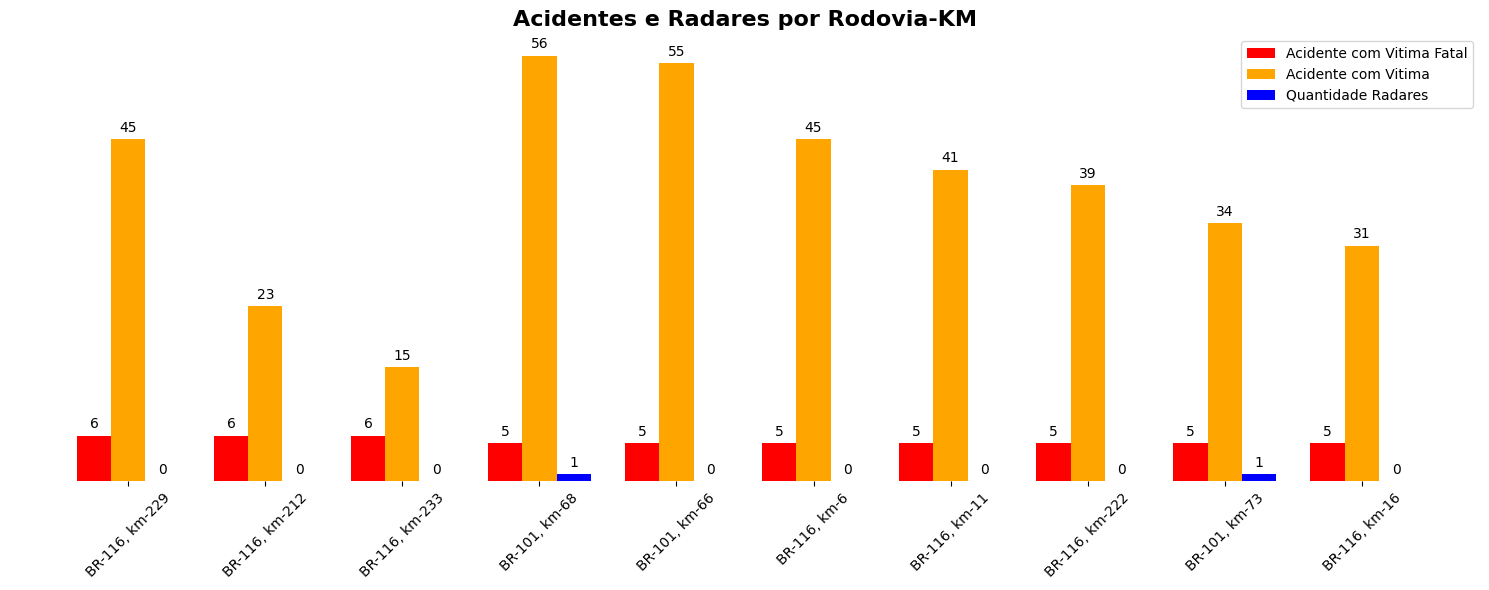

In [40]:
rodovias_km = tuple(top_10_rodovias['rodovia_km'].to_list())
colors = ['red', 'orange', 'blue']
labels = ['Acidente com Vitima Fatal', 'Acidente com Vitima', 'Quantidade Radares']

data = {
    label: {
        'data': tuple(top_10_rodovias[column].to_list()),
        'color': color
    }
    for label, column, color in zip(labels, ['acidente_com_vitima_fatal', 'acidente_com_vitima', 'quantidade_radares'], colors)
}

x = range(len(rodovias_km))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 6))

for i, (label, info) in enumerate(data.items()):
    rects = ax.bar([pos + i * width for pos in x], info['data'], width, label=label, color=info['color'])
    ax.bar_label(rects, padding=3)

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Acidentes e Radares por Rodovia-KM', fontsize=16, fontweight='bold')
ax.set_xticks([pos + width for pos in x], rodovias_km)
ax.legend(loc='upper right')
plt.xticks(rotation=45)

plt.tight_layout()

Tanto a tabela quanto o gráfico apresentados combinam informações sobre acidentes com a quantidade de radares em cada trecho das rodovias. Vários insights podem ser obtidos com base nesses dados:

* **Quantidade de Radares:** É notável que a maioria dos trechos de rodovia listados não possui radares (quantidade de radares igual a 0.0). Isso pode sugerir uma falta de fiscalização eletrônica nessas áreas, o que pode contribuir para um maior número de acidentes.

* **Rodovia com Maior Número de Acidentes Graves e Sem Radares:** A rodovia BR-101, km-68, teve o maior número de acidentes com vítimas na lista.

* **Necessidade de Fiscalização:** A ausência de radares em muitos trechos críticos destaca a necessidade de medidas de fiscalização e controle de velocidade nessas áreas para reduzir o número de acidentes com vítimas.

* **Priorização de Instalação de Radares:** Os órgãos responsáveis pela segurança viária podem considerar a instalação de radares em trechos com alto índice de acidentes graves, como a BR-101, km-66, para melhorar a segurança nessas áreas.

## 6 - Análise de proximidade

### 6.1 - Calculando a distância média dos acidentes até o radar mais próximo:

Nesta análise, calculei a distância média dos acidentes até o radar mais próximo. seguindo os passos:

1. Coletei as coordenadas geográficas dos acidentes e radares.

2. Usei a biblioteca geopy para calcular as distâncias.

3. Criei uma Árvore de Pesquisa Espacial para otimizar as buscas.
  
  - Uma Árvore de Pesquisa Espacial é uma estrutura que ajuda a encontrar informações em espaços multidimensionais, como coordenadas geográficas. Ela é útil para pesquisas eficientes em dados com componentes espaciais.

4. Calculei as distâncias mínimas para cada acidente.

5. Visualizei a distribuição das distâncias por meio de um histograma.

In [43]:
# Criando a árvore de pesquisa espacial a partir das coordenadas dos radares
radares_coords = df02_radar[['latitude', 'longitude']].to_numpy()
kdtree = cKDTree(radares_coords)

# Função para calcular a distância mínima
def calcular_distancia_minima(coord_acidente, kdtree):
    dist_minima, _ = kdtree.query(coord_acidente, k=1)
    return dist_minima

# Calculando as distâncias e adicionar uma coluna 'distancia_km' à tabela de acidentes
df02_prf['distancia_radar_km'] = df02_prf.apply(lambda row: calcular_distancia_minima((row['latitude'], row['longitude']), kdtree), axis=1)

In [44]:
df02_prf['distancia_radar_km'].describe()

count    67723.000000
mean         1.865743
std          2.769209
min          0.000022
25%          0.076180
50%          0.468643
75%          2.255329
max         17.145475
Name: distancia_radar_km, dtype: float64

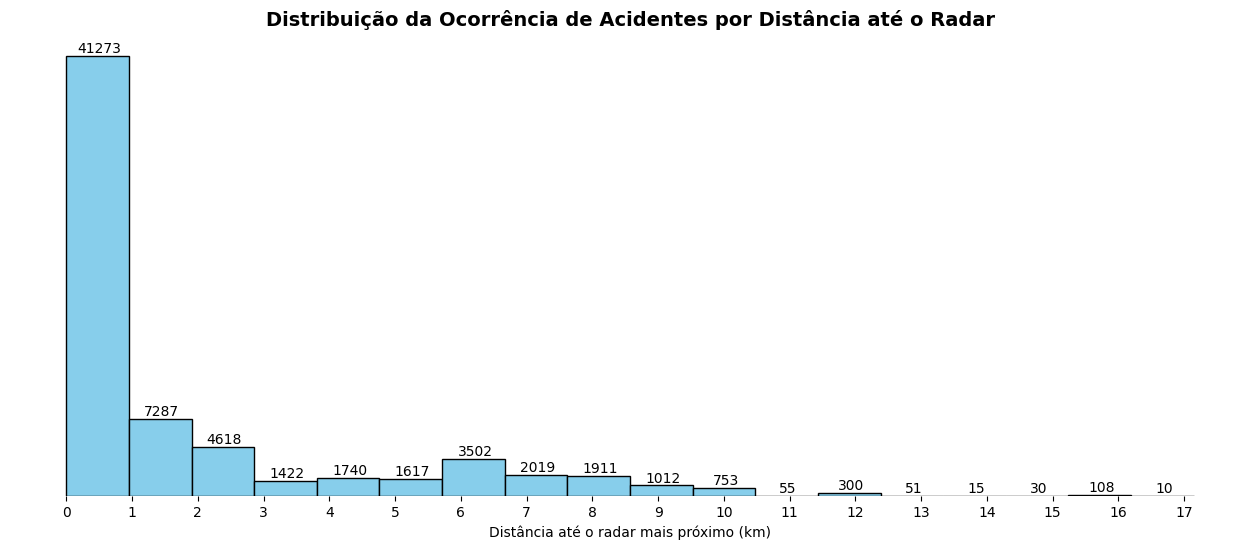

In [45]:
# Definindo o número de bins no histograma
num_bins = 18

# Criando o histograma
fig, ax = plt.subplots(figsize=(16, 6))  # Aumente as dimensões da figura
n, bins, patches = ax.hist(df02_prf['distancia_radar_km'], bins=num_bins, color='skyblue', edgecolor='black')

# Adicionando rótulos e título ao gráfico
plt.xlabel('Distância até o radar mais próximo (km)')
plt.ylabel('Número de Acidentes')
plt.title('Distribuição da Ocorrência de Acidentes por Distância até o Radar', fontsize=14, fontweight='bold')  # Adicione negrito ao título

# Removendo as margens do gráfico
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removendo a referência da coluna Y
ax.get_yaxis().set_visible(False)

# Adicionando as quantidades de cada bin em cima das barras
for i in range(num_bins):
    if n[i] > 0:
        ax.text(bins[i] + 0.5, n[i], str(int(n[i])), ha='center', va='bottom')  # Remova as casas decimais

# Removendo as casas decimais dos valores no eixo Y
plt.xticks(range(int(min(df02_prf['distancia_radar_km'])), int(max(df02_prf['distancia_radar_km']) + 1)))

# Exibindo o histograma
plt.show()

Para compreender a relação entre a distância dos acidentes em relação aos radares, conduzi uma análise que revelou insights como:

**Média de Distância:** Em média, os acidentes ocorrem a aproximadamente 1.85 km de distância de um radar. Isso indica que os acidentes geralmente ocorrem a uma distância moderada dos radares.

**Variação Considerável:** A dispersão das distâncias é notável, com acidentes variando desde muito próximos aos radares (0.000038 km) até distâncias consideráveis (máximo de 17.058496 km).

**Proximidade aos Radares:** Um quarto dos acidentes (25%) ocorre a menos de 0.081 km de um radar, enquanto metade dos acidentes (50%) ocorre a menos de 0.468 km de um radar. A maioria dos acidentes (75%) acontece a menos de 2.249 km dos radares.

**Diminuição das Ocorrências:** À medida que as distâncias entre os acidentes e os radares aumentam, a quantidade de ocorrências tende a diminuir. Isso é evidente no histograma.

**Histograma:** O histograma demonstra que a maioria dos acidentes ocorre em distâncias curtas em relação aos radares. Especificamente:

- Intervalo de 0 a 1 km: 41.273 acidentes ocorreram neste intervalo, sugerindo uma alta concentração de ocorrências próximas aos radares.

- Intervalo de 16 a 17 km: Apenas 10 acidentes ocorreram neste intervalo, indicando que as ocorrências a distâncias extremamente longas dos radares são raras.

### 6.2 - Identificando acidentes que ocorreram em locais distantes de qualquer radar

In [46]:
# Visualizar os acidentes que ocorreram a mair de 10km de distancia de um radar
df_distancias_maiores_que_10 = df02_prf[df02_prf['distancia_radar_km'] > 10]
print(f'A tabela de acidentes conta com {len(df_distancias_maiores_que_10)} acidentes que ocorreram a mais de 10km de um radar.')
print(f'Estes acidentes representam {len(df_distancias_maiores_que_10)*100/df02_prf.shape[0]:.2f}% do total de acidentes registrados.')
df_distancias_maiores_que_10[['id','distancia_radar_km']].sort_values('distancia_radar_km', ascending = False).head(10)

A tabela de acidentes conta com 919 acidentes que ocorreram a mais de 10km de um radar.
Estes acidentes representam 1.36% do total de acidentes registrados.


,id,distancia_radar_km
61473,563250,17.145475
19821,499984,17.058496
51651,548293,17.013002
38949,529083,16.861266
35684,524299,16.716899
28091,512931,16.605908
55756,554644,16.445122
39096,529325,16.393176
35522,524059,16.377125
64307,567532,16.314541


- Há 919 acidentes que ocorreram a mais de 10 km de um radar, o que representa 1.36% do total de acidentes registrados. Isso indica que a maioria dos acidentes ocorre em proximidade com radares.

- Os 10 acidentes mais distantes dos radares, ocorreram à distâncias que variam de 16.31 km a 17.14 km.

Esses pontos podem indicar áreas onde as medidas de segurança podem ser reforçadas, considerando a instalação de radares ou outras estratégias de prevenção de acidentes.

## 7 - Recomendações

Com base nos insights obtidos, podemos elencar algumas recomendações e áreas de alto risco que demandam uma melhor cobertura de radares:

- **Instalação de Radares em Trechos Críticos:** Priorizar a instalação de radares em trechos com alto índice de acidentes graves, como a "BR-116, km-229", que registrou 5 acidentes com vítimas fatais. A presença de radares pode contribuir para a redução da velocidade e a prevenção de acidentes.

- **Direcionamento de Verbas Públicas em Rodovias Frequentes:** As rodovias "BR-116" e "BR-101" aparecem frequentemente no top 10 acidentes mais graves. Portanto, é interessante considerar a instalação de radares em certos trechos dessas rodovias, dado que apresentam alta incidência de acidentes, tanto com vítimas fatais quanto com vítimas em geral.

- **Trechos Apresentam Risco Apesar dos Radares:** Mesmo trechos que já possuem radares podem ainda registrar acidentes com vítimas. Neste caso, existe a necessidade de intensificar a fiscalização ou avaliar outras alternativas para manter a segurança da população.

- **Aumentar a Cobertura em Trechos sem Radares:** Foram identificados trechos críticos que não possuem radares, como identificados na etapa "5.2". A falta de fiscalização eletrônica nessas áreas pode contribuir para um maior número de acidentes. É preciso considerar a instalação de radares nesses locais.

- **Monitoramento de Trechos Remotos:** Os acidentes que ocorrem a mais de 10 km de um radar representam uma proporção pequena, mas ainda existente. Por isso, é importante avaliar se esses locais remotos como áreas de alto risco e considerar medidas de segurança, como a instalação de radares ou outras estratégias preventivas.

Essas recomendações visam melhorar a segurança das rodovias, reduzir o número de acidentes com vítimas e garantir uma cobertura eficaz de radares em áreas críticas. É importante realizar análises contínuas dos dados de acidentes e radares para ajustar as medidas de segurança conforme necessário.

## 8 - Análise de Impacto

Para Avaliar o impacto da presença de radar na rodovia com a gravidade dos acidentes, iremos fazer um Teste AB a partir das premissas abaixo:

**Hipóteses:**

  * Hipótese Nula (H0): A presença de radares não afeta a gravidade dos acidentes (a média de vítimas fatais é a mesma nos dois grupos).

  * Hipótese Alternativa (H1): A presença de radares afeta a gravidade dos acidentes (a média de vítimas fatais é diferente nos dois grupos).

**Grupos:**

  * Grupo 1: Acidentes próximos a radares.

  * Grupo 2: Acidentes distantes de radares.

**Dados Utilizados:**

  * Considerar o número de vítimas fatais em cada acidente de ambos os grupos.

**Teste Estatístico:**

  * Será considerado um teste t independente (teste t de Student) para comparar as médias de vítimas fatais, graves, leves e ilesos entre os dois grupos. O resultado fornecerá informações sobre se a gravidade dos acidentes difere significativamente entre os grupos.

**Interpretação dos Resultados:**

  * Se o valor p for menor que um nível de significância escolhido (geralmente 0,05), você pode rejeitar a hipótese nula e concluir que a presença de radares afeta a gravidade dos acidentes.

In [49]:
# Definindo a distância para "proximidade" (em quilômetros)
distancia_proximidade = 0.5

# Dividindo os dados em dois grupos
acidentes_proximos = df02_prf[df02_prf['distancia_radar_km'] <= distancia_proximidade]
acidentes_distante = df02_prf[df02_prf['distancia_radar_km'] > distancia_proximidade]

# Gravidade dos Acidentes (Teste t independente)
# Hipóteses
# H0: As médias de vítimas fatais são iguais nos dois grupos.
# H1: As médias de vítimas fatais são diferentes nos dois grupos.
t_stat, p_valor = stats.ttest_ind(acidentes_proximos['mortos'], acidentes_distante['mortos'])
print(f"Teste para Acidentes Com Mortos - Valor t: {t_stat}, Valor p: {p_valor}")

# Hipóteses
# H0: As médias de vítimas graves são iguais nos dois grupos.
# H1: As médias de vítimas graves são diferentes nos dois grupos.
t_stat, p_valor = stats.ttest_ind(acidentes_proximos['feridos_graves'], acidentes_distante['feridos_graves'])
print(f"Teste para Acidentes Com Feridos Graves - Valor t: {t_stat}, Valor p: {p_valor}")

# Hipóteses
# H0: As médias de vítimas leves são iguais nos dois grupos.
# H1: As médias de vítimas leves são diferentes nos dois grupos.
t_stat, p_valor = stats.ttest_ind(acidentes_proximos['feridos_leves'], acidentes_distante['feridos_leves'])
print(f"Teste para Acidentes Com Feridos Leves - Valor t: {t_stat}, Valor p: {p_valor}")

# Hipóteses
# H0: As médias de ilesos são iguais nos dois grupos.
# H1: As médias de ilesos são diferentes nos dois grupos.
t_stat, p_valor = stats.ttest_ind(acidentes_proximos['ilesos'], acidentes_distante['ilesos'])
print(f"Teste para Acidentes Com Pessoas Ilesas - Valor t: {t_stat}, Valor p: {p_valor}")

Teste para Acidentes Com Mortos - Valor t: -18.05057245841726, Valor p: 1.156707351865306e-72
Teste para Acidentes Com Feridos Graves - Valor t: -21.072071676879276, Valor p: 2.9719298418307365e-98
Teste para Acidentes Com Feridos Leves - Valor t: 4.984475916627253, Valor p: 6.22829369260853e-07
Teste para Acidentes Com Pessoas Ilesas - Valor t: 2.6416376089576135, Valor p: 0.008252523482666922


Com base nos resultados dos testes t independentes:

**Acidentes com Mortos:**

* *Valor t:* -18.05

* *Valor p:* 1.15e-72

A diferença nas médias de acidentes com mortos entre os grupos é altamente estatisticamente significativa (valor p muito baixo). Isso sugere que a presença de radares impacta significativamente a ocorrência de acidentes com mortos. A média negativa indica uma menor frequência desses tipos de acidentes em áreas com radares.

**Acidentes com Feridos Graves:**

* *Valor t:* -21.07

* *Valor p:* 2.97e-98

A diferença nas médias de acidentes com feridos graves entre os grupos é altamente estatisticamente significativa (valor p muito baixo). Isso sugere que a presença de radares impacta significativamente a ocorrência de acidentes com feridos graves. A média negativa indica uma menor frequência desses tipos de acidentes em áreas com radares.

**Acidentes com Feridos Leves:**

* *Valor t:* 4.98

* *Valor p:* 6.23e-07

A diferença nas médias de acidentes com feridos leves entre os grupos é estatisticamente significativa (valor p baixo). Isso sugere que a presença de radares está associada a uma maior frequência de acidentes com feridos leves. A média positiva indica um aumento na frequência desses tipos de acidentes em áreas com radares.

**Acidentes com Pessoas Ilesas:**

* *Valor t:* 2.64

* *Valor p:* 0.008

A diferença nas médias de acidentes com pessoas ilesas entre os grupos é estatisticamente significativa (valor p moderadamente baixo). Isso sugere que a presença de radares pode ter um impacto significativo na ocorrência de acidentes com pessoas ilesas.

**Comentários Adicionais:**

Portanto, os novos resultados indicam que a presença de radares continua a impactar significativamente a gravidade e a frequência de acidentes com mortos e acidentes com feridos graves, com uma redução nesses tipos de acidentes.

## 9 - Considerações Adicionais

- Levar em conta outros fatores que podem influenciar acidentes, como condições climáticas, volume de tráfego, obras na rodovia, entre outros.

- Para isso, analisamos como a ocorrência de acidentes se distribui em relação a diferentes variáveis categóricas. Comparamos a frequência de acidentes próximos (menos de 0.5km) e distantes (mais de 0.5km) de radares para entender se a presença de radares influencia a ocorrência de acidentes em diferentes contextos.

- O resultado são vários gráficos que facilitam a visualização dessas comparações e pode revelar tendências ou padrões nos dados.

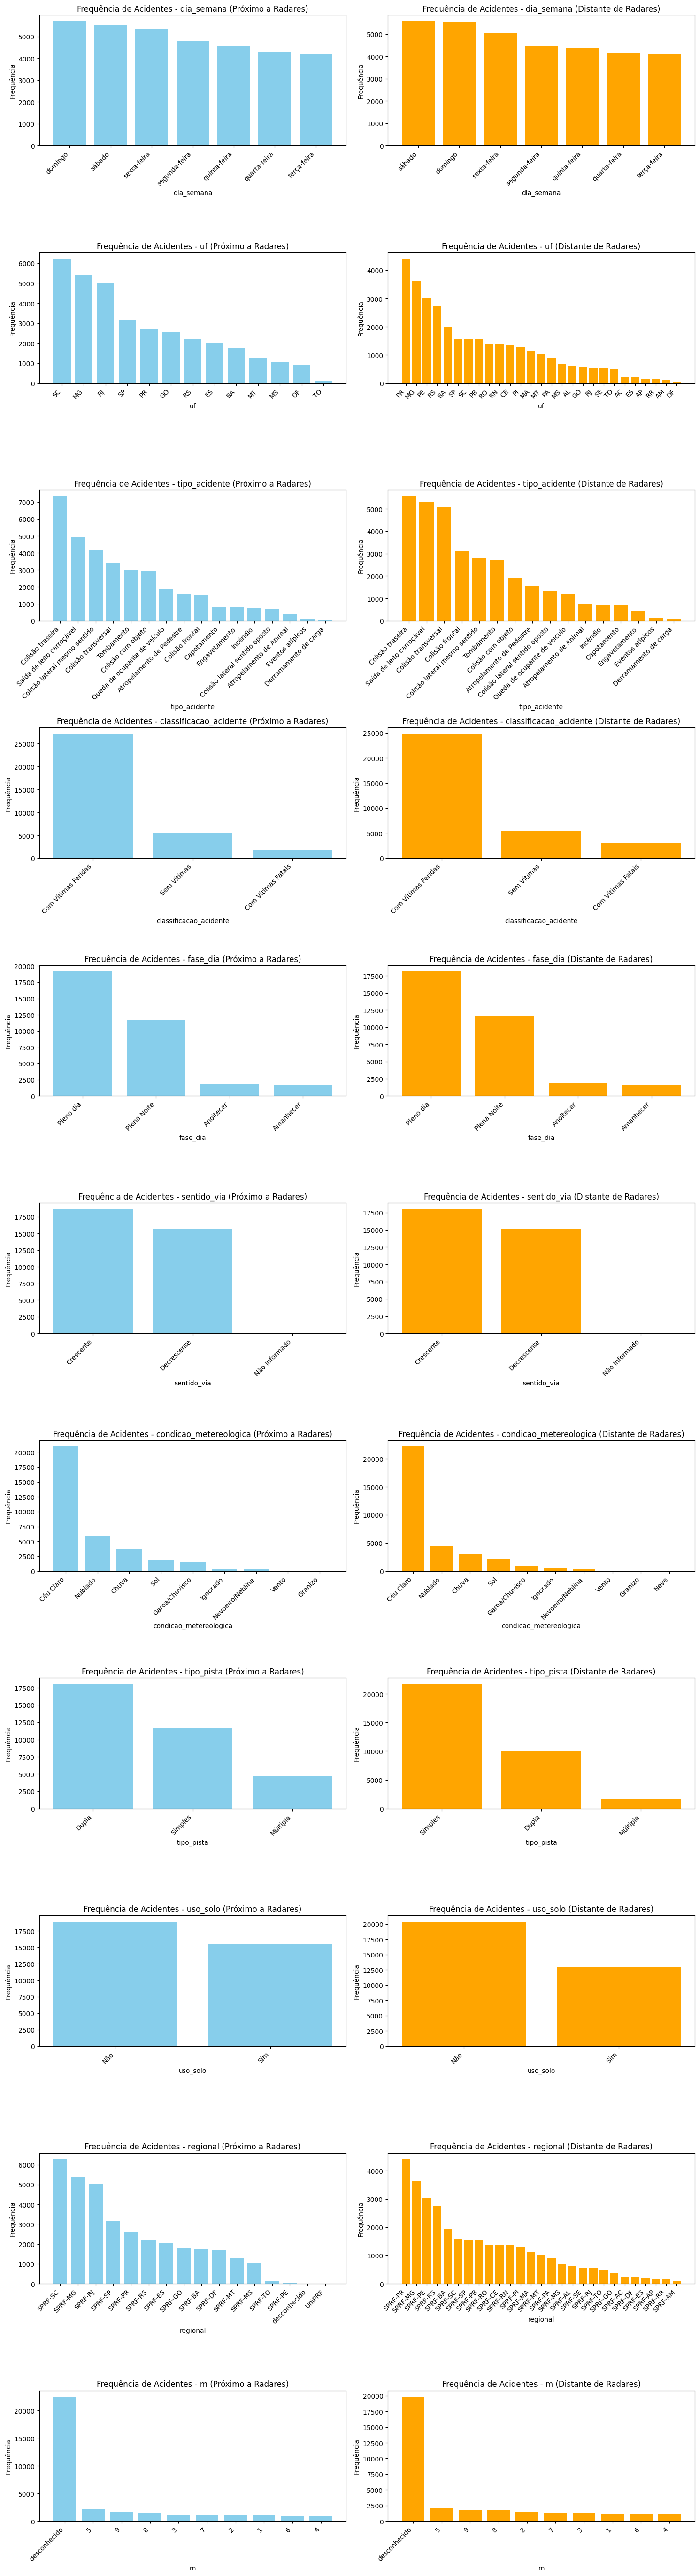

In [50]:
def plot_categorical_frequencies(df, corte_cardinalidade=30):
    # Gerando metadados para o DataFrame
    metadados = []
    for coluna in df.columns:
        metadados.append({
            'Variável': coluna,
            'Tipo': df[coluna].dtype,
            'Cardinalidade': df[coluna].nunique()
        })

    df_metadados = pd.DataFrame(metadados)

    # Filtrando colunas com cardinalidade menor ou igual ao corte e tipos não numéricos
    variaveis_categoricas = df_metadados[(df_metadados['Cardinalidade'] <= corte_cardinalidade) & (df_metadados['Tipo'] == 'object')]

    # Calculando o número de linhas e colunas para os subplots
    n_linhas = len(variaveis_categoricas)
    n_colunas = 2  # Você pode ajustar o número de colunas conforme necessário

    # Criando subplots
    fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(15, 5 * n_linhas))

    for i, (idx, linha) in enumerate(variaveis_categoricas.iterrows()):
        var = linha['Variável']
        ax = axs[i]

        for j, radar_proximity in enumerate(['Próximo a Radares', 'Distante de Radares']):
            ax[j].set_title(f'Frequência de Acidentes - {var} ({radar_proximity})')
            ax[j].set_xlabel(var)
            ax[j].set_ylabel('Frequência')

            if radar_proximity == 'Próximo a Radares':
                data = df[df['distancia_radar_km'] <= 0.5]
            else:
                data = df[df['distancia_radar_km'] > 0.5]

            x = range(len(data[var].value_counts().index))
            ax[j].bar(x, data[var].value_counts().values, color='skyblue' if radar_proximity == 'Próximo a Radares' else 'orange')
            ax[j].set_xticks(x)
            ax[j].set_xticklabels(data[var].value_counts().index, rotation=45, ha='right')  # Rotação dos rótulos do eixo x

    plt.tight_layout()
    plt.show()

# Chamando a função com o DataFrame desejado
plot_categorical_frequencies(df02_prf, corte_cardinalidade=30)

A partir dos histogramas apresentados, é possível retirar alguns insights relevantes com base nas frequências de variáveis para acidentes próximos e distantes de radares:

**Dia da Semana (dia_semana):**

- Sábado e Domingo são os dias da semana com o maior número de acidentes em ambos os grupos.
- Não há uma diferença significativa entre os dois grupos em relação ao dia da semana dos acidentes.

**UF (estado):**

- Em acidentes próximos a radares, Santa Catarina (SC) é o estado mais comum, seguido por Minas Gerais (MG) e Rio de Janeiro (RJ).

- Em acidentes distantes de radares, Paraná (PR) lidera, seguido por Minas Gerais (MG) e Pernambuco (PE).

**Tipo de Acidente (tipo_acidente):**

- Em acidentes próximos e distantes a radares, "Colisão traseira" é o tipo mais comum, seguido por "Saída de leito carroçável".

**Classificação do Acidente (classificacao_acidente):**

- Ambos os grupos têm a maioria dos acidentes classificados como "Com Vítimas Feridas".

**Tipo de Pista (tipo_pista):**

- Em acidentes próximos a radares, "Dupla" é o tipo mais comum, enquanto em acidentes distantes, "Simples" lidera.

- Essa é outra divergência significativa entre os grupos.

**Regional:**

- A regional "SPRF-SC" é a mais comum em acidentes próximos a radares, enquanto "SPRF-PR" lidera em acidentes distantes.

- Há uma grande divergência nas regionais mais comuns em cada grupo.

## 10 - Conclusão

**Principais Insights:**

- **Eficiência dos Radares:** A presença de radares impacta significativamente na redução de acidentes com mortos e feridos graves, com uma correlação estatistica significativa.

- **Pontos Críticos:** A análise identificou áreas de alto risco, como a "BR-101, km-68", que demandam uma melhor cobertura de radares. Além disso, certas rodovias, como "BR-116", frequentemente registram acidentes graves, sugerindo a necessidade de instalação de radares em trechos específicos.

- **Economia e Justificação de Investimentos:** Além dos aspectos de segurança, é importante considerar o impacto econômico dos acidentes ao avaliar o investimento em radares, pois acidentes rodoviários têm custos substanciais, incluindo custos médicos em regiões onde ocorrem os acidentes.

**Recomendações de Melhorias nas Rodovias Federais:**

- **Instalação de Radares em Trechos Críticos:** Priorizar a instalação de radares em trechos com alta incidência de acidentes graves, como a "BR-116, km-229", para prevenir acidentes com vítimas fatais.

- **Direcionamento de Recursos em Rodovias Frequentes:** Considerar a instalação de radares em trechos específicos de rodovias, como "BR-116" e "BR-101", que frequentemente registram acidentes graves, para reduzir a gravidade desses acidentes.

- **Avaliação Contínua:** Realizar análises contínuas dos dados de acidentes e radares para ajustar as medidas de segurança conforme necessário e garantir que os radares estejam nos lugares certos.

**Sugestões de Medidas de Segurança Além dos Radares:**

- **Sinalização Eficiente:** Investir em sinalização de trânsito eficaz, incluindo placas de advertência, limites de velocidade e sinalização de curvas perigosas, para manter os motoristas informados.

- **Policiamento nas Estradas:** Reforçar o policiamento de trânsito em áreas de alto risco para garantir o cumprimento das leis de trânsito e promover um ambiente seguro.

- **Manutenção de Rodovias:** Priorizar a manutenção adequada das rodovias, incluindo reparos de pavimento e remoção de obstáculos perigosos, para garantir estradas em boas condições.

Essas medidas de segurança, combinadas com a eficácia dos radares, podem contribuir para a redução de acidentes e melhorar a qualidade do trânsito nas rodovias, atendendo aos objetivos de tornar as estradas mais seguras e eficientes.